### Import the package and split the data set (add a little data preprocessing, because the output.csv here has already been preprocessed)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC

# 1. Load data (please replace with your data file path)
df = pd.read_csv("output.csv")  # Assume you have converted it to CSV format

# 2. Data preprocessing
X = df.drop(columns=["Outcome"])  # Features
y = df["Outcome"]  # Target variable

# Standardize data (helpful for logistic regression)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Split training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


In [2]:
!pip install xgboost

### Five models are trained here, namely Logistic Regression, XGBoost, MLP, XGBoost + optimizer, random forest

In [3]:
# 4. Train models

# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logreg_preds = logreg.predict(X_test)

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)

# MLP
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, alpha=0.01, random_state=42)
mlp.fit(X_train, y_train)
mlp_preds = mlp.predict(X_test)

# XGBoost + Optimizer
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}
grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)
grid_preds = grid.predict(X_test)
print("Best params:", grid.best_params_)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:03:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:03:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:03:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:03:08] WARNING: /workspace/src/learner.cc:740: 
Parameter

Best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}


### Two models are trained here, which are ensemble models and different from the above. Finally, the evaluation task is performed

In [4]:
# Create a voting classifier (hard voting)
voting_clf = VotingClassifier(
    estimators=[
        ('logreg', logreg),
        ('xgb', xgb),
        ('mlp', mlp),
        ('rf', rf)
    ],
    voting='hard'  # 'hard' represents majority voting, 'soft' uses probability-weighted voting
)
# Train the ensemble model
voting_clf.fit(X_train, y_train)
# Predict
voting_preds = voting_clf.predict(X_test)

# Create a stacking model
stacking_clf = StackingClassifier(
    estimators=[
        ('logreg', logreg),
        ('xgb', xgb),
        ('mlp', mlp),
        ('rf', rf)
    ],
    final_estimator=SVC(probability=True)  # Use Support Vector Machine as the meta-learner
)
# Train the model
stacking_clf.fit(X_train, y_train)
# Predict
stacking_preds = stacking_clf.predict(X_test)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:04:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:04:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:04:23] WARNING: /workspace/src/learner.c

Logistic Regression Model Performance:
Accuracy: 0.7013
ROC AUC: 0.6550
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       100
           1       0.59      0.50      0.54        54

    accuracy                           0.70       154
   macro avg       0.67      0.66      0.66       154
weighted avg       0.69      0.70      0.70       154

--------------------------------------------------
XGBoost Model Performance:
Accuracy: 0.7078
ROC AUC: 0.6770
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.78      0.78       100
           1       0.58      0.57      0.58        54

    accuracy                           0.71       154
   macro avg       0.68      0.68      0.68       154
weighted avg       0.71      0.71      0.71       154

--------------------------------------------------
MLPClassifier Model Performance:
Accuracy: 0.7468
ROC AUC: 0.6943


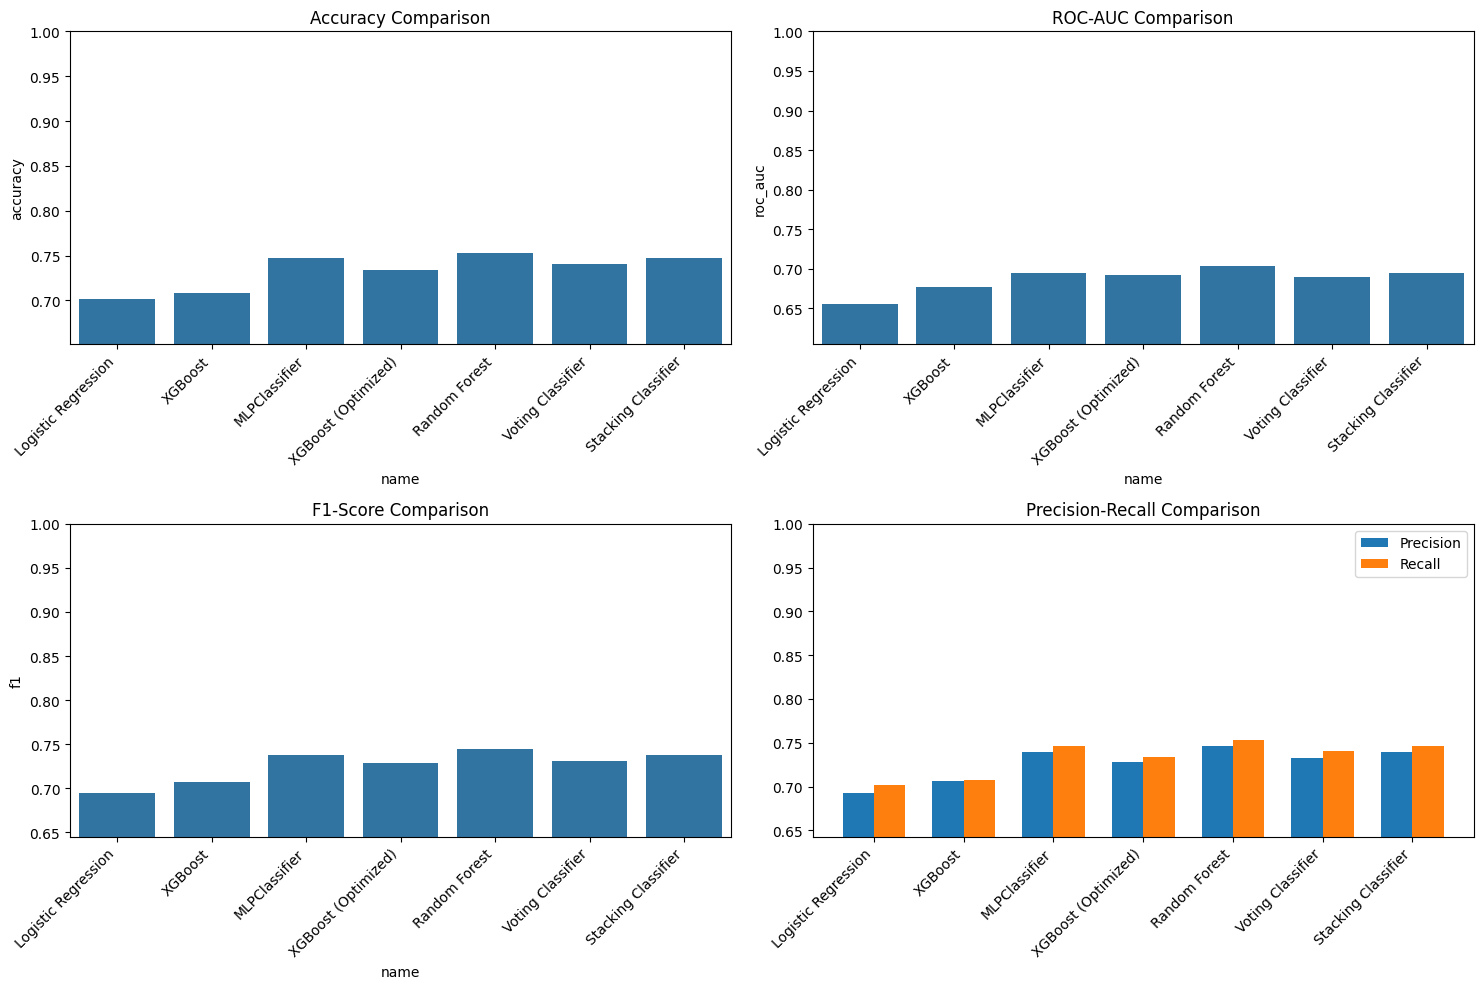


MODEL PERFORMANCE INTERPRETATION
Best model by accuracy: Random Forest (0.7532)
Best model by ROC-AUC: Random Forest (0.7035)
Best model by F1-score: Random Forest (0.7448)
Best model by precision: Random Forest (0.7465)
Best model by recall: Random Forest (0.7532)

Metric Interpretation:
- Accuracy: Proportion of correct predictions among the total number of cases
- ROC-AUC: Ability to distinguish between classes (higher is better)
- Precision: Proportion of true positives among positive predictions (focus on minimizing false positives)
- Recall: Proportion of true positives identified correctly (focus on minimizing false negatives)
- F1-score: Harmonic mean of precision and recall (balance between precision and recall)

Model Selection Guidance:
- For balanced datasets: Consider the model with highest accuracy or F1-score
- For imbalanced datasets: ROC-AUC and F1-score are more reliable than accuracy
- When false positives are costly: Prioritize models with high precision
- When fal

In [5]:
# 5. 评估模型
def evaluate_model(name, y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True)

    print(f"{name} Model Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    print("-"*50)

    # Return metrics for later comparison
    return {
        'name': name,
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1': report['weighted avg']['f1-score']
    }

# Store results for comparison
results = []
results.append(evaluate_model("Logistic Regression", y_test, logreg_preds))
results.append(evaluate_model("XGBoost", y_test, xgb_preds))
results.append(evaluate_model("MLPClassifier", y_test, mlp_preds))
results.append(evaluate_model("XGBoost (Optimized)", y_test, grid_preds))
results.append(evaluate_model("Random Forest", y_test, rf_preds))

# ... existing code for voting and stacking classifiers ...

# Add ensemble results
results.append(evaluate_model("Voting Classifier", y_test, voting_preds))
results.append(evaluate_model("Stacking Classifier", y_test, stacking_preds))

# Create a DataFrame for easy comparison
results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:")
print(results_df.set_index('name'))

# Visualize the results
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Plot accuracy comparison
plt.subplot(2, 2, 1)
sns.barplot(x='name', y='accuracy', data=results_df)
plt.title('Accuracy Comparison')
plt.xticks(rotation=45, ha='right')
plt.ylim(results_df['accuracy'].min() - 0.05, 1.0)

# Plot ROC-AUC comparison
plt.subplot(2, 2, 2)
sns.barplot(x='name', y='roc_auc', data=results_df)
plt.title('ROC-AUC Comparison')
plt.xticks(rotation=45, ha='right')
plt.ylim(results_df['roc_auc'].min() - 0.05, 1.0)

# Plot F1-score comparison
plt.subplot(2, 2, 3)
sns.barplot(x='name', y='f1', data=results_df)
plt.title('F1-Score Comparison')
plt.xticks(rotation=45, ha='right')
plt.ylim(results_df['f1'].min() - 0.05, 1.0)

# Plot Precision-Recall comparison
plt.subplot(2, 2, 4)
width = 0.35
x = np.arange(len(results_df))
plt.bar(x - width/2, results_df['precision'], width, label='Precision')
plt.bar(x + width/2, results_df['recall'], width, label='Recall')
plt.xticks(x, results_df['name'], rotation=45, ha='right')
plt.title('Precision-Recall Comparison')
plt.legend()
plt.ylim(min(results_df['precision'].min(), results_df['recall'].min()) - 0.05, 1.0)

plt.tight_layout()
plt.savefig('model_performance_comparison.png')
plt.show()

# Add model interpretation section
print("\n" + "="*80)
print("MODEL PERFORMANCE INTERPRETATION")
print("="*80)

# Find the best model for each metric
best_accuracy = results_df.loc[results_df['accuracy'].idxmax()]
best_roc_auc = results_df.loc[results_df['roc_auc'].idxmax()]
best_f1 = results_df.loc[results_df['f1'].idxmax()]
best_precision = results_df.loc[results_df['precision'].idxmax()]
best_recall = results_df.loc[results_df['recall'].idxmax()]

print(f"Best model by accuracy: {best_accuracy['name']} ({best_accuracy['accuracy']:.4f})")
print(f"Best model by ROC-AUC: {best_roc_auc['name']} ({best_roc_auc['roc_auc']:.4f})")
print(f"Best model by F1-score: {best_f1['name']} ({best_f1['f1']:.4f})")
print(f"Best model by precision: {best_precision['name']} ({best_precision['precision']:.4f})")
print(f"Best model by recall: {best_recall['name']} ({best_recall['recall']:.4f})")

print("\nMetric Interpretation:")
print("- Accuracy: Proportion of correct predictions among the total number of cases")
print("- ROC-AUC: Ability to distinguish between classes (higher is better)")
print("- Precision: Proportion of true positives among positive predictions (focus on minimizing false positives)")
print("- Recall: Proportion of true positives identified correctly (focus on minimizing false negatives)")
print("- F1-score: Harmonic mean of precision and recall (balance between precision and recall)")

print("\nModel Selection Guidance:")
print("- For balanced datasets: Consider the model with highest accuracy or F1-score")
print("- For imbalanced datasets: ROC-AUC and F1-score are more reliable than accuracy")
print("- When false positives are costly: Prioritize models with high precision")
print("- When false negatives are costly: Prioritize models with high recall")
print("- For overall performance: Consider ensemble methods like Stacking or Voting")